# Model Comparison: Strong Baseline vs Extensions 1–3

This notebook compares **Strong Baseline**, **Extension 1**, **Extension 2**, and **Extension 3** on:

- **SARI** (plus keep/delete/add components)
- **Latency** (ms per example)

It also evaluates a 5th setting:

- **Extension 3 + beam-techniques**: applying Extension 2’s adaptive decoding + context-aware length penalty to the Extension 3 architecture.

All comparisons are run across completion ratios **25%, 50%, 75%, 100%** (prefix-based incremental inputs), matching the setup used in `extension2.ipynb`.

In [9]:
import os
import json
import time
import shutil
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt

from transformers import AutoConfig, AutoTokenizer, T5ForConditionalGeneration
from transformers.modeling_outputs import BaseModelOutput

from score import sari_score

# Repro / display
np.random.seed(5300)
plt.rcParams["figure.dpi"] = 120

# Runtime config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LENGTH = 128
COMPLETION_RATIOS = [0.25, 0.5, 0.75, 1.0]

# For quick iteration: set to an int like 50; set to None for full test set
EVAL_N: int | None = 50

print("DEVICE:", DEVICE)

DEVICE: cpu


In [10]:
# Load local dataset (offline-friendly)
# Expected columns: Normal (source), Simple (reference)
TEST_PATH = os.path.join("data", "test.csv")

if not os.path.exists(TEST_PATH):
    raise FileNotFoundError(f"Missing {TEST_PATH}.")

test_df = pd.read_csv(TEST_PATH)
if EVAL_N is not None:
    test_df = test_df.head(EVAL_N).reset_index(drop=True)

required_cols = {"Normal", "Simple"}
missing = required_cols - set(test_df.columns)
if missing:
    raise ValueError(f"test_df missing columns: {missing}")

print("Loaded test examples:", len(test_df))
print(test_df.head(3))

Loaded test examples: 50
                                              Normal  \
0  his next work saturday follows an especially e...   
1  the tarantula the trickster character spun a b...   
2          there he died six weeks later on january.   

                                              Simple  
0  his next work at saturday will be a successful...  
1  the tarantuala the trickster spun a black chor...  
2             he died six weeks later on january th.  


In [11]:
def ensure_dir_from_zip(zip_path: str, out_dir: str) -> None:
    """Ensure `out_dir` exists by extracting `zip_path` if needed."""
    if os.path.isdir(out_dir):
        return
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Missing {zip_path} and {out_dir} does not exist.")

    os.makedirs(out_dir, exist_ok=True)
    print(f"Extracting {zip_path} -> {out_dir} ...")
    shutil.unpack_archive(zip_path, out_dir)


# Strong baseline checkpoint
BASELINE_DIR = "t5-simplification"
BASELINE_ZIP = "t5-simplification.zip"

# Extension 3 checkpoint (encoder-adapter architecture)
EXT3_DIR = "t5-simplification-2"
EXT3_ZIP = "t5-simplification-2.zip"

# Baseline is already present in this repo in most cases; keep this robust anyway.
if not os.path.isdir(BASELINE_DIR):
    # The baseline zip in this repo is archived with a 'content/t5-simplification/' prefix.
    # We extract to a temp directory and then move the actual folder into place.
    tmp_extract = "_tmp_extract_baseline"
    if os.path.isdir(tmp_extract):
        shutil.rmtree(tmp_extract)
    os.makedirs(tmp_extract, exist_ok=True)

    print(f"Extracting {BASELINE_ZIP} -> {tmp_extract} ...")
    shutil.unpack_archive(BASELINE_ZIP, tmp_extract)

    candidate = os.path.join(tmp_extract, "content", "t5-simplification")
    if not os.path.isdir(candidate):
        raise FileNotFoundError(
            f"Expected {candidate} after extracting {BASELINE_ZIP}, but it was not found."
        )

    shutil.move(candidate, BASELINE_DIR)
    shutil.rmtree(tmp_extract)

# Extension 3 is only zipped in this repo snapshot
ensure_dir_from_zip(EXT3_ZIP, EXT3_DIR)

print("Baseline dir ok:", os.path.isdir(BASELINE_DIR))
print("Ext3 dir ok:", os.path.isdir(EXT3_DIR))

Baseline dir ok: True
Ext3 dir ok: True


In [12]:
# ----- Extension 3 model definition (copied/simplified from extension3.ipynb) -----

class EncoderBottleneckAdapter(nn.Module):
    def __init__(self, d_model: int, bottleneck: int = 256, dropout: float = 0.1):
        super().__init__()
        self.down = nn.Linear(d_model, bottleneck)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.up = nn.Linear(bottleneck, d_model)
        self.ln = nn.LayerNorm(d_model)
        # Trainable scalar gate initialized near 0: start close to plain T5
        self.gate = nn.Parameter(torch.tensor(0.0))

    def forward(self, h: torch.Tensor) -> torch.Tensor:
        delta = self.up(self.dropout(self.act(self.down(h))))
        return self.ln(h + torch.tanh(self.gate) * delta)


@dataclass
class AdapterConfig:
    bottleneck: int
    dropout: float


class T5WithEncoderAdapter(nn.Module):
    def __init__(self, base_model_name: str, bottleneck: int = 256, dropout: float = 0.1):
        super().__init__()
        config = AutoConfig.from_pretrained(base_model_name, local_files_only=True)
        self.base = T5ForConditionalGeneration.from_pretrained(
            base_model_name,
            config=config,
            local_files_only=True,
        )
        d_model = self.base.config.d_model
        self.adapter = EncoderBottleneckAdapter(d_model=d_model, bottleneck=bottleneck, dropout=dropout)
        self.adapter_cfg = AdapterConfig(bottleneck=bottleneck, dropout=dropout)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        enc = self.base.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        h = self.adapter(enc.last_hidden_state)
        encoder_outputs = BaseModelOutput(
            last_hidden_state=h,
            hidden_states=enc.hidden_states,
            attentions=enc.attentions,
        )
        return self.base(
            encoder_outputs=encoder_outputs,
            attention_mask=attention_mask,
            labels=labels,
            return_dict=True,
            **kwargs,
        )

    @torch.no_grad()
    def generate(self, input_ids=None, attention_mask=None, **gen_kwargs):
        enc = self.base.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        h = self.adapter(enc.last_hidden_state)
        encoder_outputs = BaseModelOutput(
            last_hidden_state=h,
            hidden_states=enc.hidden_states,
            attentions=enc.attentions,
        )
        return self.base.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_outputs=encoder_outputs,
            **gen_kwargs,
        )

    @classmethod
    def load(cls, output_dir: str):
        base_dir = os.path.join(output_dir, "base")
        with open(os.path.join(output_dir, "adapter_config.json"), "r") as f:
            cfg = json.load(f)
        model = cls(base_model_name=base_dir, bottleneck=cfg["bottleneck"], dropout=cfg["dropout"])
        sd = torch.load(os.path.join(output_dir, "adapter.pt"), map_location="cpu")
        model.adapter.load_state_dict(sd)
        return model


# ----- Load Extension 3 checkpoint -----
# Baseline / Ext1 / Ext2 numbers are hardcoded below, so we don't need to load the baseline model.

print("Loading Extension 3 model...")
ext3_tokenizer = AutoTokenizer.from_pretrained(EXT3_DIR, local_files_only=True)
ext3_model = T5WithEncoderAdapter.load(EXT3_DIR).to(DEVICE)
ext3_model.eval()

print("Loaded ext3 model.")

Loading Extension 3 model...
Loaded ext3 model.


In [13]:
# --- Shared helpers (from extension2.ipynb) ---

def get_sentence_prefix(source: str, completion_ratio: float) -> str:
    tokens = source.split()
    num_tokens = len(tokens)
    prefix_length = max(1, int(num_tokens * completion_ratio))
    return " ".join(tokens[:prefix_length])


def compute_context_aware_length_penalty(source: str, completion_ratio: float) -> float:
    source_length = len(source.split())

    # Base length penalty increases with completion ratio
    base_penalty = 0.4 + (completion_ratio * 0.4)  # Range: 0.4 to 0.8

    # Adjust based on source length
    if source_length < 10:
        length_factor = 0.9
    elif source_length < 20:
        length_factor = 1.0
    else:
        length_factor = 1.1

    final_penalty = base_penalty * length_factor
    return max(0.3, min(1.0, final_penalty))


def _encode(tokenizer, text: str):
    return tokenizer(
        text,
        max_length=MAX_LENGTH,
        truncation=True,
        return_tensors="pt",
    ).to(DEVICE)

In [14]:
# --- Decoding strategies ---

def simplify_fixed(
    model,
    tokenizer,
    source: str,
    completion_ratio: float,
    *,
    num_beams: int = 4,
    length_penalty: float = 0.6,
    no_repeat_ngram_size: int = 2,
) -> Tuple[str, float]:
    """Strong baseline-style decoding with fixed generation params."""
    prefix = get_sentence_prefix(source, completion_ratio)
    enc = _encode(tokenizer, "simplify: " + prefix)

    t0 = time.perf_counter()
    with torch.no_grad():
        out_ids = model.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            max_length=MAX_LENGTH,
            num_beams=num_beams,
            length_penalty=length_penalty,
            early_stopping=True,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=False,
        )
    t1 = time.perf_counter()

    pred = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    return pred, (t1 - t0)


def simplify_ext1_adaptive_lenpen(
    model,
    tokenizer,
    source: str,
    completion_ratio: float,
    *,
    num_beams: int = 4,
    no_repeat_ngram_size: int = 2,
) -> Tuple[str, float]:
    """Extension 1: adaptive length penalty based on completion ratio."""
    if completion_ratio <= 0.25:
        length_penalty = 0.4
    elif completion_ratio <= 0.5:
        length_penalty = 0.5
    elif completion_ratio <= 0.75:
        length_penalty = 0.6
    else:
        length_penalty = 0.7

    return simplify_fixed(
        model,
        tokenizer,
        source,
        completion_ratio,
        num_beams=num_beams,
        length_penalty=length_penalty,
        no_repeat_ngram_size=no_repeat_ngram_size,
    )


def simplify_ext2_adaptive_decoding(
    model,
    tokenizer,
    source: str,
    completion_ratio: float,
    *,
    no_repeat_ngram_size: int = 2,
) -> Tuple[str, float]:
    """Extension 2: greedy early (<=50%), beam later, context-aware length penalty."""
    prefix = get_sentence_prefix(source, completion_ratio)

    if completion_ratio <= 0.5:
        num_beams = 1
    else:
        num_beams = 4

    length_penalty = compute_context_aware_length_penalty(source, completion_ratio)

    enc = _encode(tokenizer, "simplify: " + prefix)

    t0 = time.perf_counter()
    with torch.no_grad():
        out_ids = model.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            max_length=MAX_LENGTH,
            num_beams=num_beams,
            length_penalty=length_penalty,
            early_stopping=True,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=False,
        )
    t1 = time.perf_counter()

    pred = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    return pred, (t1 - t0)

In [15]:
def eval_over_completion_ratios(
    model,
    tokenizer,
    df: pd.DataFrame,
    simplify_fn,
    *,
    label: str,
) -> Dict[float, Dict[str, List[float]]]:
    """Returns results[ratio] = {'sari','keep','delete','add','latency_s'} lists."""
    results: Dict[float, Dict[str, List[float]]] = {
        r: {"sari": [], "keep": [], "delete": [], "add": [], "latency_s": []}
        for r in COMPLETION_RATIOS
    }

    iterator = tqdm(df.itertuples(index=False), total=len(df), desc=f"eval: {label}")
    for row in iterator:
        source = str(getattr(row, "Normal"))
        reference = str(getattr(row, "Simple"))

        for r in COMPLETION_RATIOS:
            pred, latency_s = simplify_fn(model, tokenizer, source, r)
            s, comps = sari_score(source, pred, [reference])
            results[r]["sari"].append(float(s))
            results[r]["keep"].append(float(comps["keep"]))
            results[r]["delete"].append(float(comps["delete"]))
            results[r]["add"].append(float(comps["add"]))
            results[r]["latency_s"].append(float(latency_s))

    return results


def mean_series(results: Dict[float, Dict[str, List[float]]], key: str) -> List[float]:
    return [float(np.mean(results[r][key])) for r in COMPLETION_RATIOS]


def ms_series(results: Dict[float, Dict[str, List[float]]]) -> List[float]:
    return [float(np.mean(results[r]["latency_s"])) * 1000.0 for r in COMPLETION_RATIOS]

In [16]:
# Precomputed results for Strong Baseline / Ext1 / Ext2 (from extension2.ipynb)
# These are means over the full 191-example test set used in that notebook.

if EVAL_N is not None:
    print(
        "WARNING: EVAL_N is set, but baseline/ext1/ext2 metrics are hardcoded for the full test set. "
        "Ext3 metrics will reflect the subset; others will not."
    )

PRECOMPUTED = {
    "Strong Baseline (fixed)": {
        0.25: {"SARI": 28.74, "KEEP": 22.90, "DELETE": 61.76, "ADD": 1.56, "latency_ms": 141.43},
        0.50: {"SARI": 32.25, "KEEP": 39.16, "DELETE": 54.19, "ADD": 3.39, "latency_ms": 199.08},
        0.75: {"SARI": 33.92, "KEEP": 47.98, "DELETE": 48.95, "ADD": 4.81, "latency_ms": 262.21},
        1.00: {"SARI": 36.01, "KEEP": 58.18, "DELETE": 40.10, "ADD": 9.75, "latency_ms": 324.99},
    },
    "Extension 1 (adaptive lenpen)": {
        0.25: {"SARI": 28.74, "KEEP": 22.90, "DELETE": 61.76, "ADD": 1.56, "latency_ms": 142.51},
        0.50: {"SARI": 32.27, "KEEP": 39.14, "DELETE": 54.28, "ADD": 3.39, "latency_ms": 200.18},
        0.75: {"SARI": 33.92, "KEEP": 47.98, "DELETE": 48.95, "ADD": 4.81, "latency_ms": 263.16},
        1.00: {"SARI": 35.94, "KEEP": 58.44, "DELETE": 39.58, "ADD": 9.81, "latency_ms": 326.59},
    },
    "Extension 2 (adaptive decoding)": {
        0.25: {"SARI": 28.75, "KEEP": 22.76, "DELETE": 61.82, "ADD": 1.67, "latency_ms": 108.58},
        0.50: {"SARI": 32.55, "KEEP": 40.33, "DELETE": 54.56, "ADD": 2.77, "latency_ms": 163.53},
        0.75: {"SARI": 33.84, "KEEP": 48.17, "DELETE": 48.52, "ADD": 4.81, "latency_ms": 263.66},
        1.00: {"SARI": 36.14, "KEEP": 58.89, "DELETE": 39.06, "ADD": 10.47, "latency_ms": 325.56},
    },
}

# Evaluate only the Extension 3 systems (so the notebook runs fast)
SYSTEMS_TO_RUN = {
    "Extension 3 (arch, fixed)": {
        "model": ext3_model,
        "tokenizer": ext3_tokenizer,
        "fn": simplify_fixed,
    },
    "Extension 3 + beam-techniques": {
        # Apply Extension 2 decoding strategy (adaptive beams + context-aware length penalty)
        "model": ext3_model,
        "tokenizer": ext3_tokenizer,
        "fn": simplify_ext2_adaptive_decoding,
    },
}

# Keep raw per-example results only for the systems we re-evaluate
all_results: Dict[str, Dict[float, Dict[str, List[float]]]] = {}

for name, cfg in SYSTEMS_TO_RUN.items():
    all_results[name] = eval_over_completion_ratios(
        cfg["model"],
        cfg["tokenizer"],
        test_df,
        cfg["fn"],
        label=name,
    )

# Build a unified summary table (hardcoded + measured)
rows: List[dict] = []

for sys_name, per_ratio in PRECOMPUTED.items():
    for r in COMPLETION_RATIOS:
        m = per_ratio[float(r)]
        rows.append(
            {
                "system": sys_name,
                "completion_ratio": float(r),
                "SARI": float(m["SARI"]),
                "KEEP": float(m["KEEP"]),
                "DELETE": float(m["DELETE"]),
                "ADD": float(m["ADD"]),
                "latency_ms": float(m["latency_ms"]),
            }
        )

for sys_name, res in all_results.items():
    for r in COMPLETION_RATIOS:
        rows.append(
            {
                "system": sys_name,
                "completion_ratio": float(r),
                "SARI": float(np.mean(res[r]["sari"])),
                "KEEP": float(np.mean(res[r]["keep"])),
                "DELETE": float(np.mean(res[r]["delete"])),
                "ADD": float(np.mean(res[r]["add"])),
                "latency_ms": float(np.mean(res[r]["latency_s"])) * 1000.0,
            }
        )

summary_df = pd.DataFrame(rows)
summary_df["completion_pct"] = (summary_df["completion_ratio"] * 100).astype(int)

print("Done (precomputed baseline/ext1/ext2 + evaluated ext3 variants).")

eval: Extension 3 + beam-techniques: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]

Done (precomputed baseline/ext1/ext2 + evaluated ext3 variants).


In [17]:
# Summary tables

# Keep a stable column ordering for plots/tables
SYSTEM_ORDER = [
    "Strong Baseline (fixed)",
    "Extension 1 (adaptive lenpen)",
    "Extension 2 (adaptive decoding)",
    "Extension 3 (arch, fixed)",
    "Extension 3 + beam-techniques",
]

pivot_sari = summary_df.pivot(index="completion_pct", columns="system", values="SARI").reindex(
    columns=SYSTEM_ORDER
)
pivot_lat = summary_df.pivot(index="completion_pct", columns="system", values="latency_ms").reindex(
    columns=SYSTEM_ORDER
)

print("SARI (mean):")
display(pivot_sari.round(2))

print("Latency (ms, mean):")
display(pivot_lat.round(2))

overall = (
    summary_df.groupby("system")
    .agg(
        overall_SARI=("SARI", "mean"),
        overall_latency_ms=("latency_ms", "mean"),
    )
    .reindex(SYSTEM_ORDER)
)

print("Overall averages (mean across completion ratios):")
display(overall.round(3))

SARI (mean):


system,Strong Baseline (fixed),Extension 1 (adaptive lenpen),Extension 2 (adaptive decoding),"Extension 3 (arch, fixed)",Extension 3 + beam-techniques
completion_pct,,,,,
25,28.74,28.74,28.75,26.95,27.19
50,32.25,32.27,32.55,32.86,33.05
75,33.92,33.92,33.84,37.07,37.31
100,36.01,35.94,36.14,36.74,36.43


Latency (ms, mean):


system,Strong Baseline (fixed),Extension 1 (adaptive lenpen),Extension 2 (adaptive decoding),"Extension 3 (arch, fixed)",Extension 3 + beam-techniques
completion_pct,,,,,
25,141.43,142.51,108.58,285.23,87.46
50,199.08,200.18,163.53,330.82,109.54
75,262.21,263.16,263.66,380.39,382.41
100,324.99,326.59,325.56,456.38,453.49


Overall averages (mean across completion ratios):


,overall_SARI,overall_latency_ms
system,,
Strong Baseline (fixed),32.730,231.928
Extension 1 (adaptive lenpen),32.718,233.110
Extension 2 (adaptive decoding),32.820,215.332
"Extension 3 (arch, fixed)",33.403,363.205
Extension 3 + beam-techniques,33.494,258.224


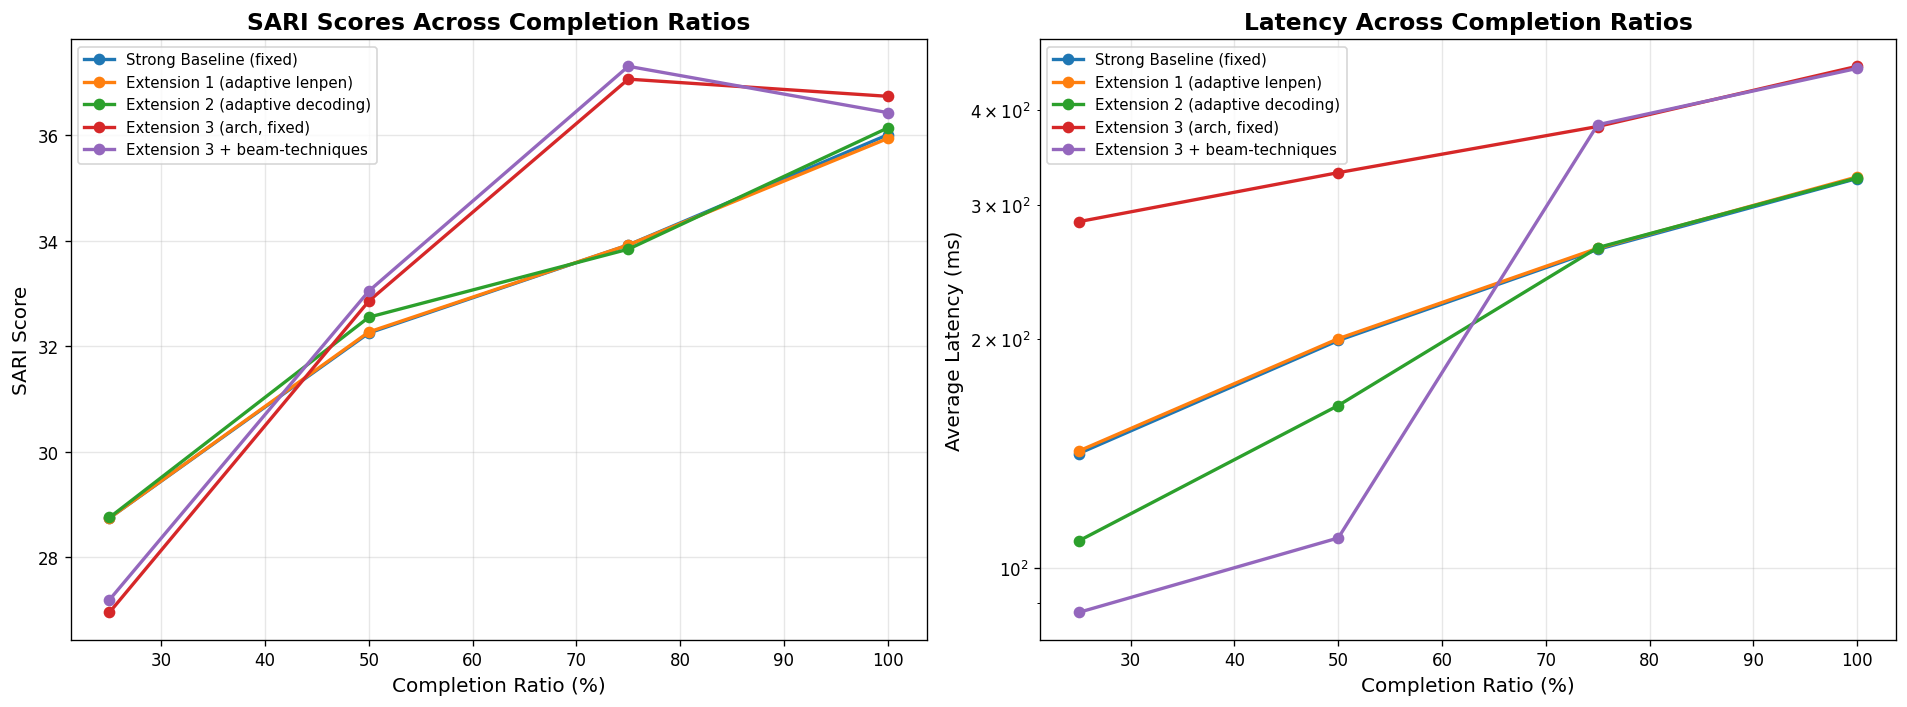

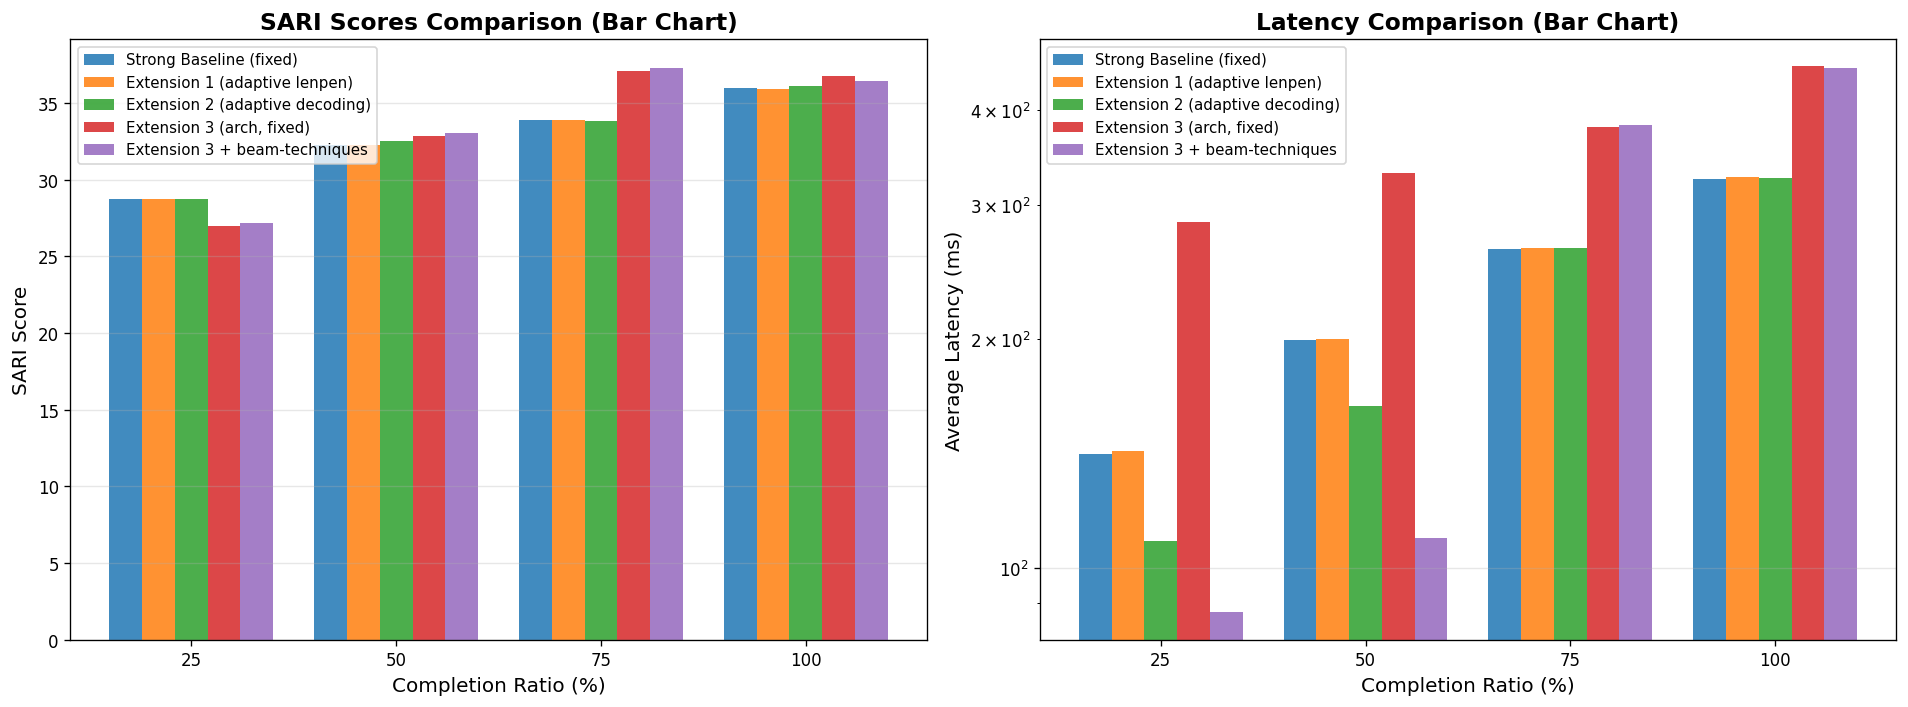

In [18]:
# Plots (line + bar) in the same style as extension2.ipynb, now mixing:
# - precomputed Baseline/Ext1/Ext2
# - measured Ext3 variants

ratios = [int(r * 100) for r in COMPLETION_RATIOS]

# Build ordered series from pivot tables
labels = SYSTEM_ORDER
sari_series = {name: pivot_sari[name].tolist() for name in labels}
lat_series = {name: pivot_lat[name].tolist() for name in labels}

# --- Line plots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for name in labels:
    ax1.plot(ratios, sari_series[name], marker="o", linewidth=2, markersize=6, label=name)

ax1.set_xlabel("Completion Ratio (%)", fontsize=12)
ax1.set_ylabel("SARI Score", fontsize=12)
ax1.set_title("SARI Scores Across Completion Ratios", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9)

for name in labels:
    ax2.plot(ratios, lat_series[name], marker="o", linewidth=2, markersize=6, label=name)

ax2.set_xlabel("Completion Ratio (%)", fontsize=12)
ax2.set_ylabel("Average Latency (ms)", fontsize=12)
ax2.set_title("Latency Across Completion Ratios", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.set_yscale("log")
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()

# --- Bar plots ---
fig, (bx1, bx2) = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(ratios))
width = 0.16

for i, name in enumerate(labels):
    offset = (i - (len(labels) - 1) / 2) * width
    bx1.bar(x + offset, sari_series[name], width, label=name, alpha=0.85)

bx1.set_xlabel("Completion Ratio (%)", fontsize=12)
bx1.set_ylabel("SARI Score", fontsize=12)
bx1.set_title("SARI Scores Comparison (Bar Chart)", fontsize=14, fontweight="bold")
bx1.set_xticks(x)
bx1.set_xticklabels(ratios)
bx1.grid(True, alpha=0.3, axis="y")
bx1.legend(fontsize=9)

for i, name in enumerate(labels):
    offset = (i - (len(labels) - 1) / 2) * width
    bx2.bar(x + offset, lat_series[name], width, label=name, alpha=0.85)

bx2.set_xlabel("Completion Ratio (%)", fontsize=12)
bx2.set_ylabel("Average Latency (ms)", fontsize=12)
bx2.set_title("Latency Comparison (Bar Chart)", fontsize=14, fontweight="bold")
bx2.set_xticks(x)
bx2.set_xticklabels(ratios)
bx2.set_yscale("log")
bx2.grid(True, alpha=0.3, axis="y")
bx2.legend(fontsize=9)

plt.tight_layout()
plt.show()

### Notes / knobs

- **To run faster**: set `EVAL_N = 50` (or similar) near the top.
- **Fairness**: `Extension 3 (arch, fixed)` uses the same fixed decoding params as the strong baseline (`num_beams=4`, `length_penalty=0.6`) so the architectural change is isolated.
- **Beam-techniques entry**: `Extension 3 + beam-techniques` applies Extension 2’s *adaptive decoding + context-aware length penalty* on top of the Extension 3 architecture, creating the 5th series on both plots.